In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from patsy import dmatrices
%matplotlib inline

# Data processing

In [2]:
train = pd.read_csv("~/Desktop/Benz/train.csv", index_col =0)
test = pd.read_csv("~/Desktop/Benz/test.csv", index_col=0)
df = train.drop('y', axis=1).append(test)
train_X = train.drop('y', axis=1)

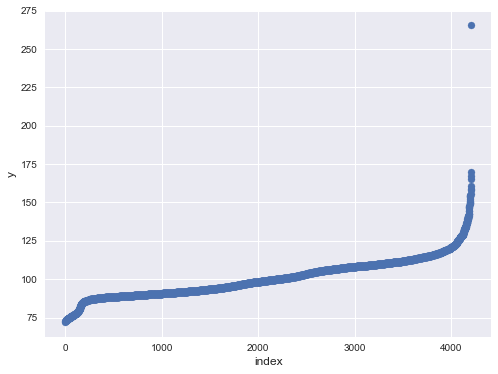

In [3]:
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train.y.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

Y variable Highly right skewed

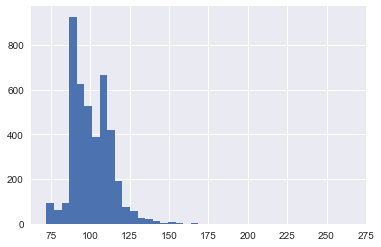

In [4]:
train.y.hist(bins = 40)

Following predictors are objects, others are numerical

In [5]:
object_predictors = train.dtypes[train.dtypes=='object']
object_predictors.index.values

array(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'], dtype=object)

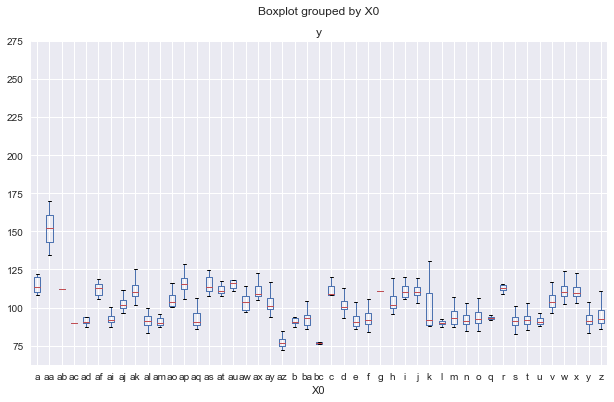

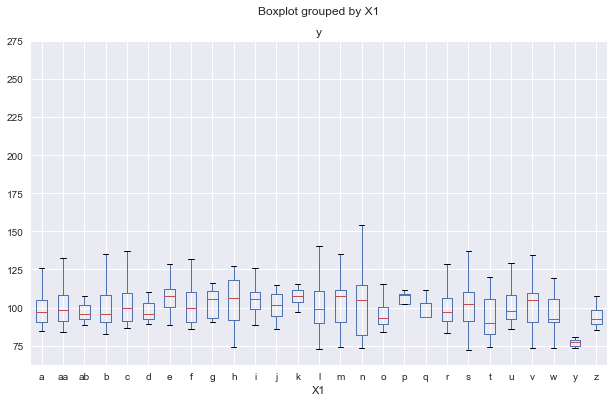

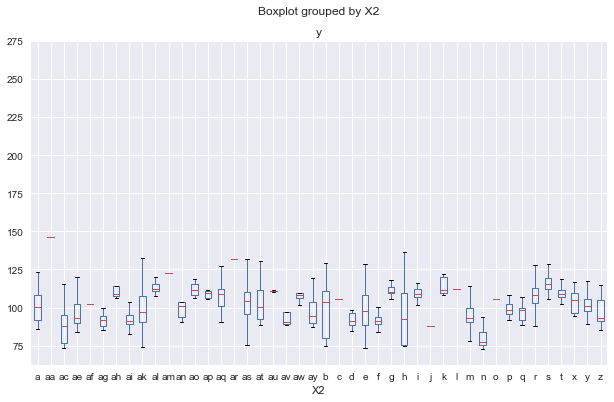

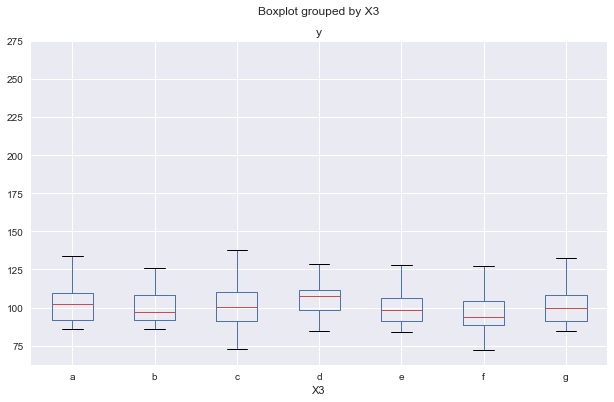

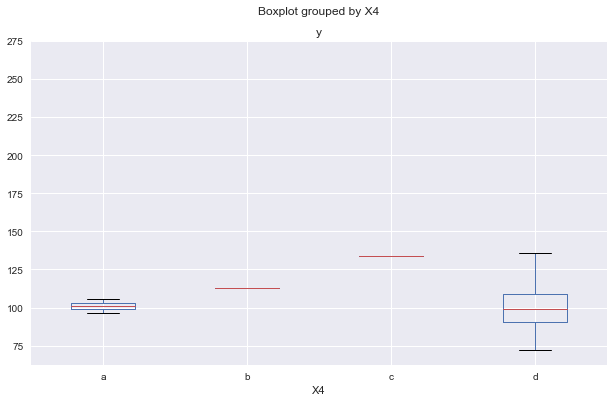

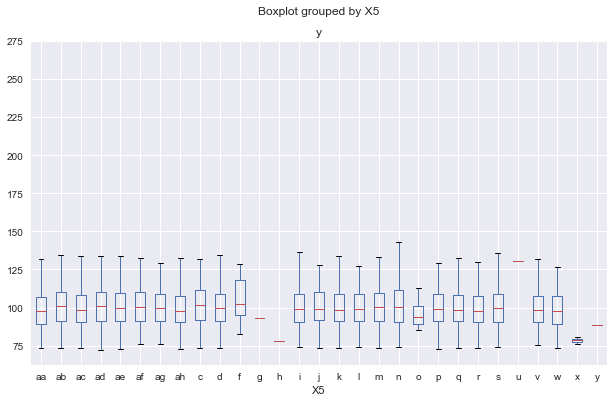

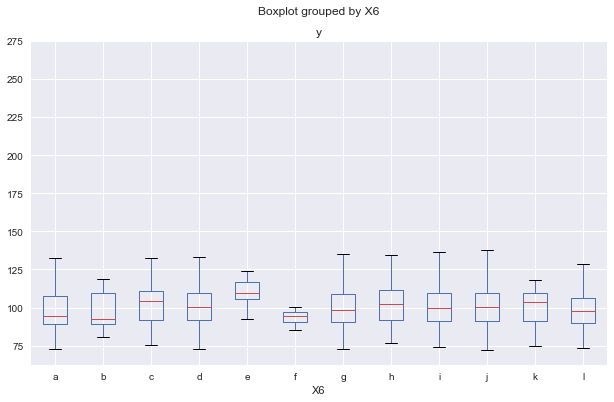

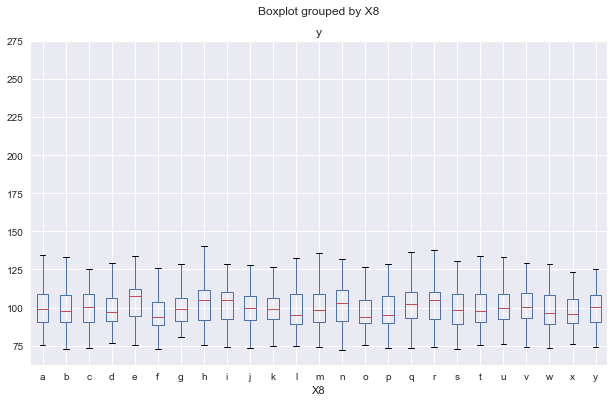

In [6]:
for o in object_predictors.index.values:
    train.boxplot(column='y', by=o, figsize=(10, 6))

Numeric predictors

In [7]:
num_predictors = train_X.dtypes[train_X.dtypes!='object']
num_predictors = num_predictors.index.values

Features that have only one level of values bring no information for regression and should be removed

In [8]:
zero_predictors = []
for i in num_predictors:
    if len(train_X[i].unique()) !=2:
        zero_predictors.append(i)

In [9]:
zero_predictors

['X11',
 'X93',
 'X107',
 'X233',
 'X235',
 'X268',
 'X289',
 'X290',
 'X293',
 'X297',
 'X330',
 'X347']

In [10]:
df = df.drop(zero_predictors, axis = 1)

In [11]:
num_predictors = [x for x in num_predictors if x not in zero_predictors]

I calculated the ratio of how many ones have appeared in each remaining numeric columns. Substract 0.5 and plot the absolute value. It's more balanced when the value is close to 0.5 and imbalanced when close to 0. Looks as most columsn are balanced.

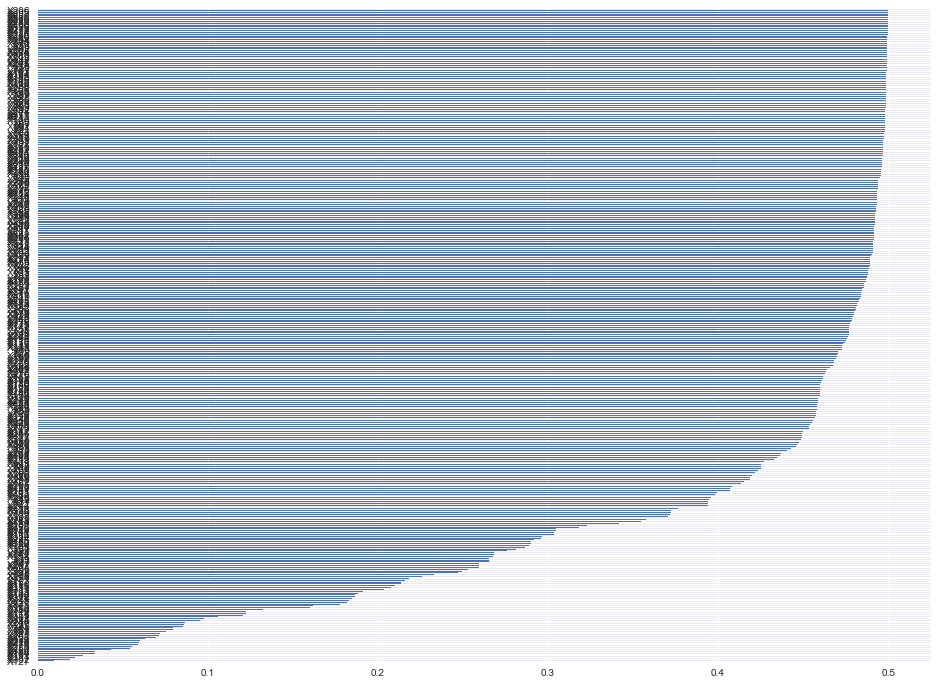

In [12]:
abs((df[num_predictors].T.sum(axis=1)/len(df))-0.5).sort_values(ascending = True).plot(kind='barh', 
                                                                       figsize = (16,12))

A rule of thumb for detecting near-zero variance predictors is:
1. The fraction of unique values over the sample size is low (say 10 %).
2. The ratio of the frequency of the most prevalent value to the frequency of the second most prevalent value is large (say around 20).”

Excerpt From: Max Kuhn and Kjell Johnson. “Applied Predictive Modeling.” iBooks. 

So I removed those predictors whose percentage of 1 are above 0.9 or below 0.1.

In [13]:
one_percentage = df[num_predictors].T.sum(axis=1)/len(train)
near_zero_predictors = one_percentage[(one_percentage >=0.9) | (one_percentage <= 0.1)].index.values

In [14]:
df = df.drop(near_zero_predictors, axis = 1)

In [15]:
num_predictors = [x for x in num_predictors if x not in near_zero_predictors]

Missing values: no missing values in this dataset. Good!

In [16]:
df.columns[df.isnull().sum()!=0]

Index([], dtype='object')

Correlation between predictors. It can be seen that numerous pairs of predictors are highly positively or negatively related. 

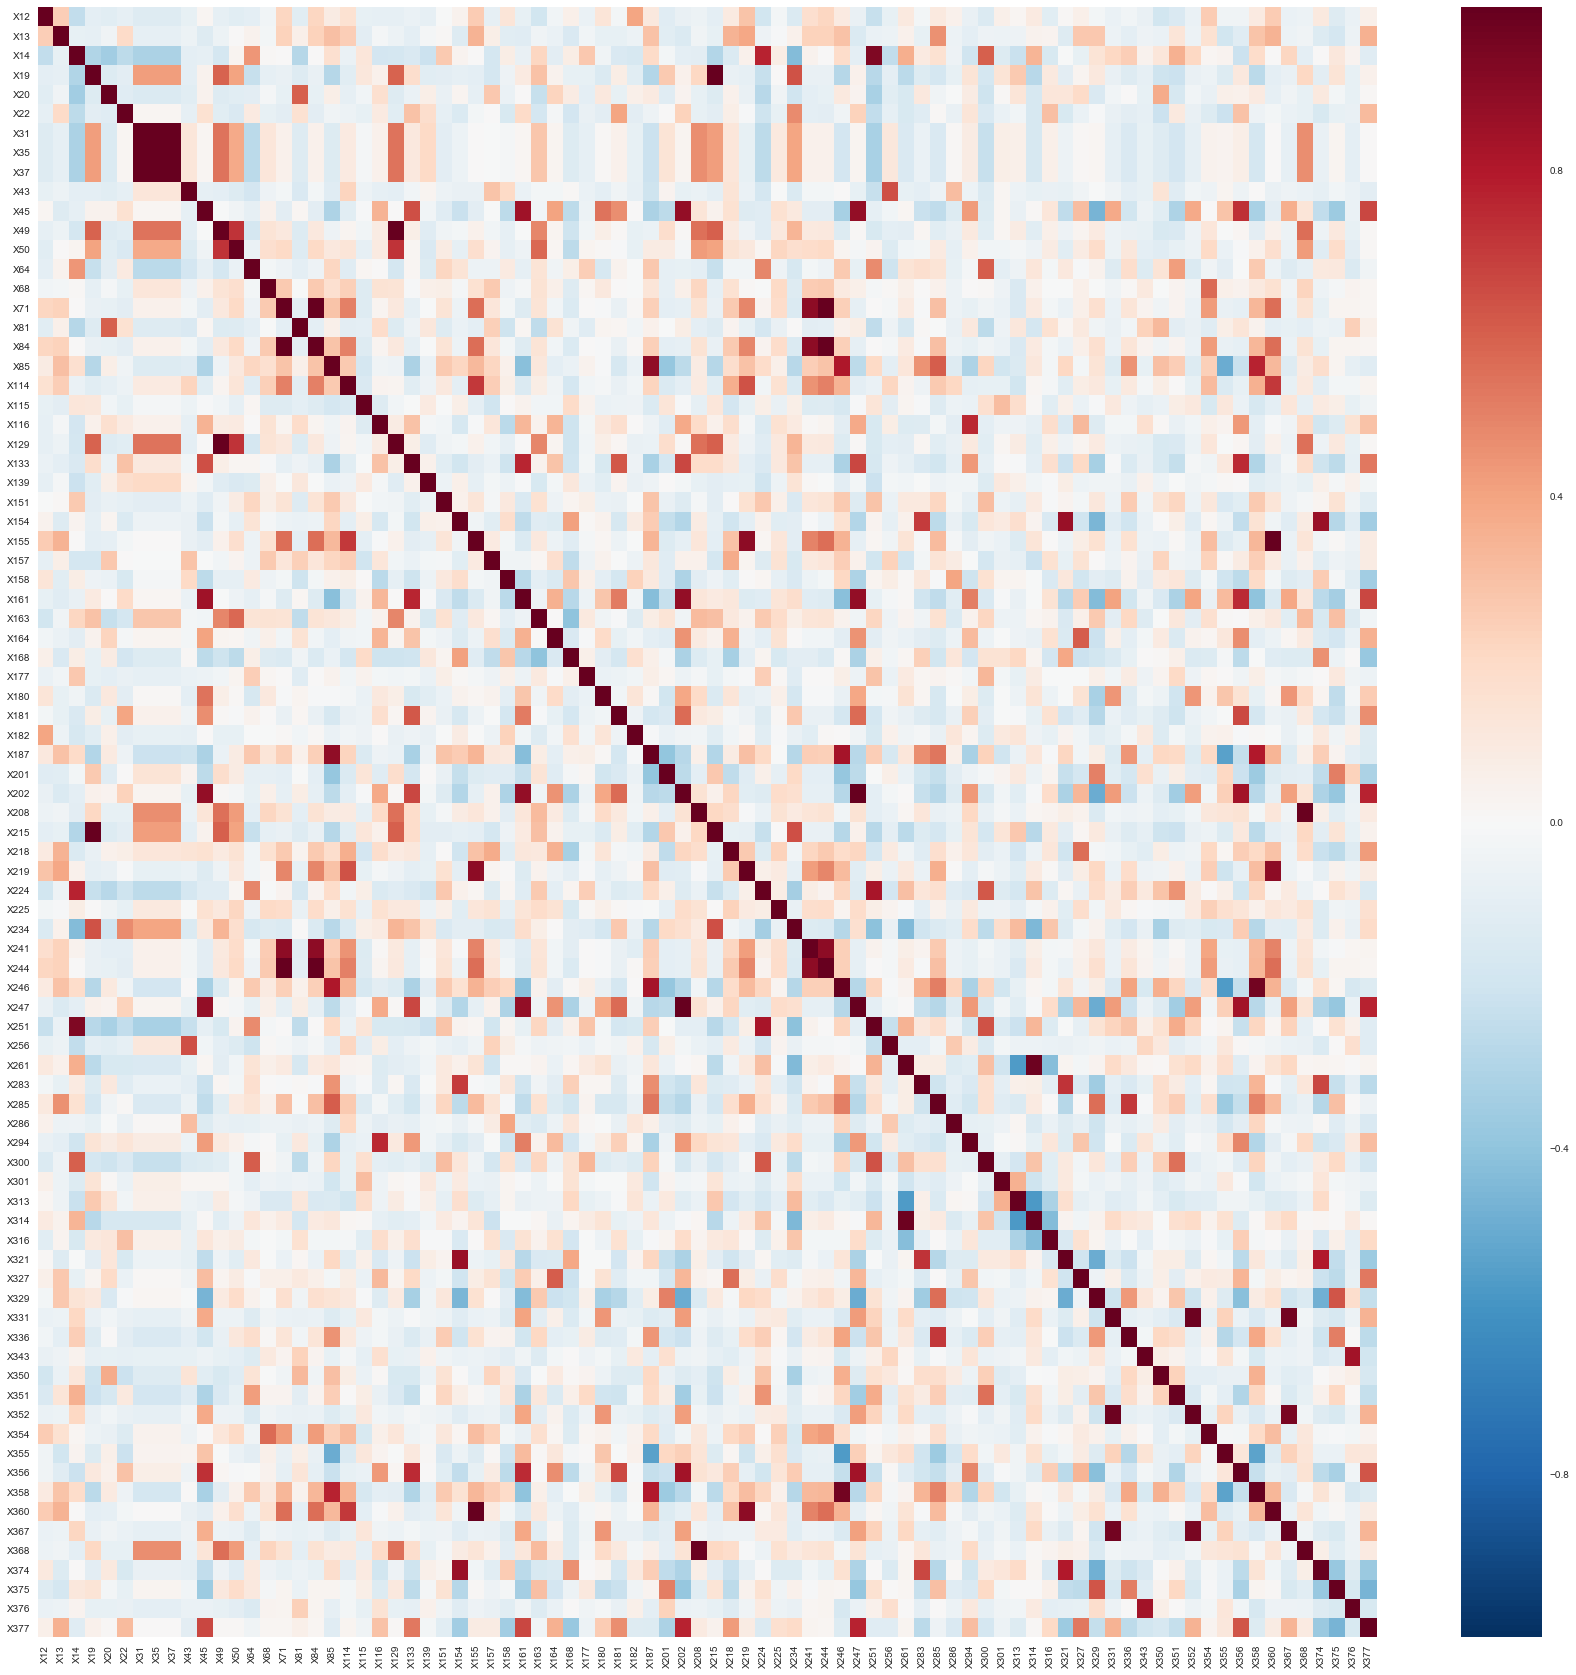

In [17]:
corr_df = df[num_predictors]
corr = corr_df.corr()
plt.subplots(figsize=(30,30))
sns.heatmap(corr)

An algorithm to remove correlated predictors:

1.
Calculate the correlation matrix of the predictors.
 
2.
Determine the two predictors associated with the largest absolute pairwise correlation (call them predictors A and B).
 
3.
Determine the average correlation between A and the other variables. Do the same for predictor B.
 
4.
If A has a larger average correlation, remove it; otherwise, remove predictor B.
 
5.
Repeat Steps 2–4 until no absolute correlations are above the threshold”

Excerpt From: Max Kuhn and Kjell Johnson. “Applied Predictive Modeling.” iBooks. 

In this dataset, I set the 0.7 as the threshold. After running the algorithm, the number of columns has been deducted to 47.

In [18]:
def find_max(df_c):
    max_ = 0
    max_i = 0
    max_j = 0
    for i in range(len(df_c.columns)):
        for j in range(i+1, len(df_c.columns)):
            if abs(df_c.iloc[i, j]) > max_:
                max_i = i
                max_j = j
                max_ = abs(df_c.iloc[i, j])
    return max_i, max_j, max_

In [19]:
drop_list = []
while True:
    c1, c2, cor = find_max(corr)
    if cor < 0.7:
        break
    else:
        if corr.iloc[c1].mean() > corr.iloc[c2].mean():
            corr_df = corr_df.drop(corr.columns[c1], axis=1)
            drop_list.append(corr.columns[c1])
        else:
            corr_df = corr_df.drop(corr.columns[c2], axis=1)
            drop_list.append(corr.columns[c2])
        corr = corr_df.corr()

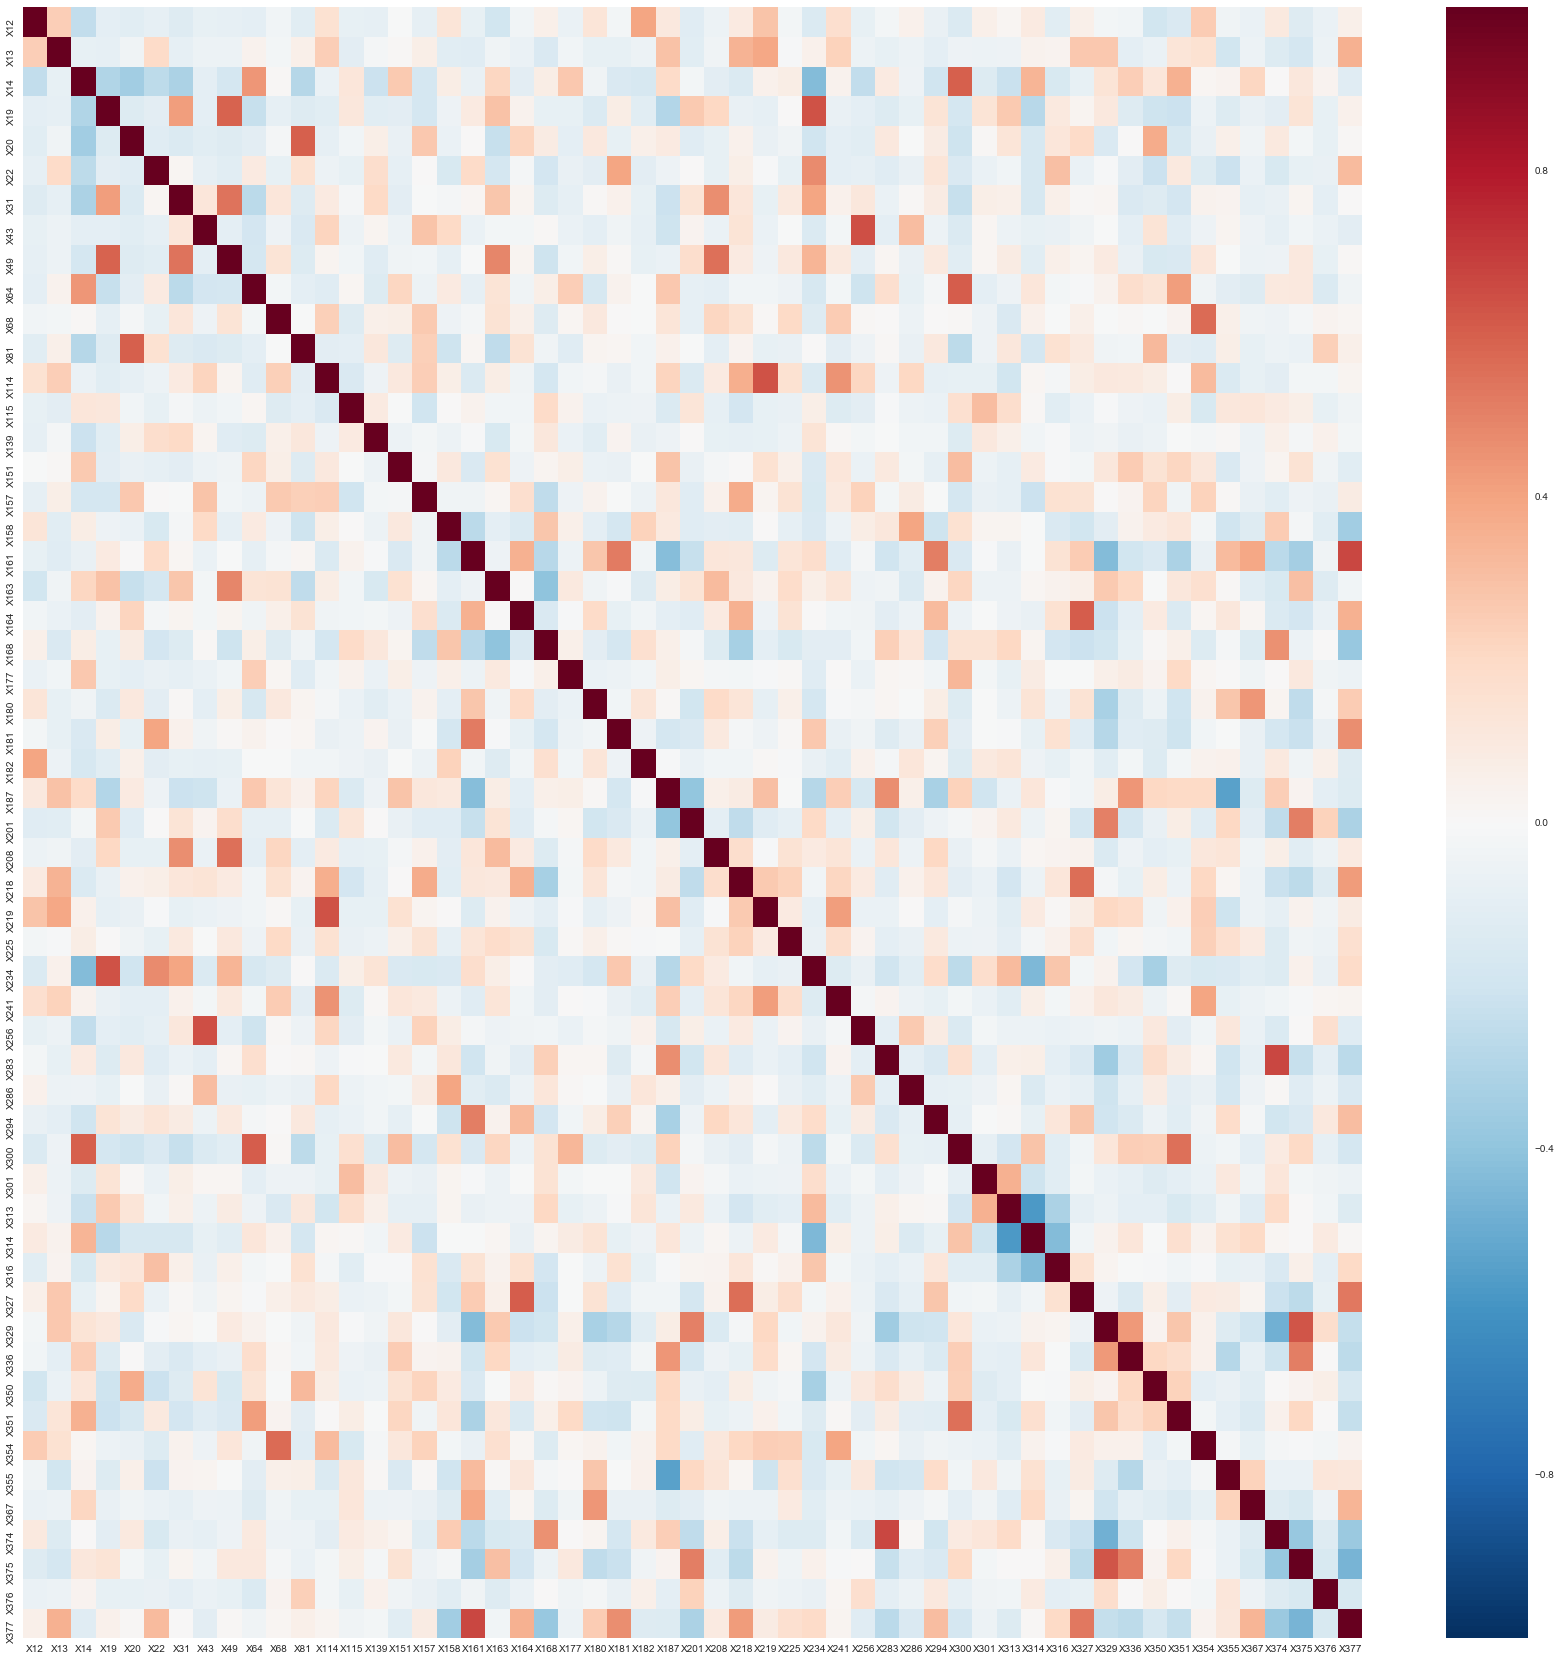

In [20]:
plt.subplots(figsize=(30,30))
sns.heatmap(corr)

In [21]:
df = df.drop(drop_list, axis =1)

Then we translate the categoricals to dummies

In [22]:
df = pd.get_dummies(df)

PCA to further reduce number of dimensions

In [23]:
from sklearn.decomposition import PCA

In [24]:
pca = PCA(n_components=len(df.columns))
pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=266, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

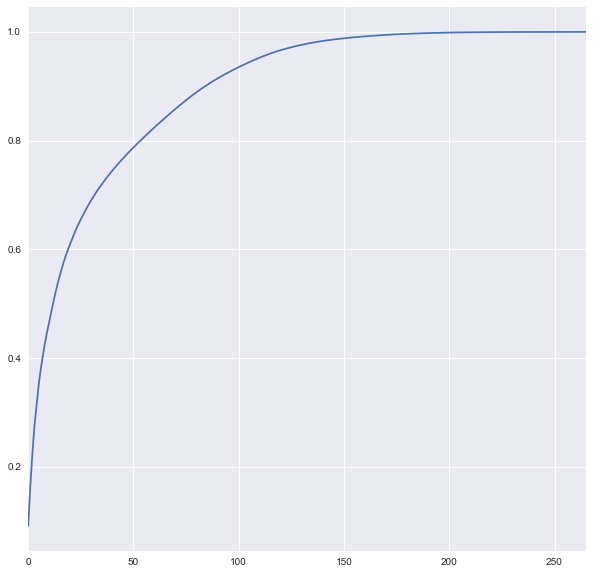

In [26]:
pd.Series(pca.explained_variance_ratio_).cumsum().plot(figsize=(10,10))